# Introduction

## About the MLB

## Motivation for the project

## General approach and TL;DR


# Loading Everything We Need

In [1]:
import math
import os
import warnings

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore", "use_inf_as_na")

/kaggle/input/mlb-hitting-and-pitching-stats-through-the-years/baseball_pitcher.csv
/kaggle/input/mlb-hitting-and-pitching-stats-through-the-years/baseball_hitting.csv


# Data Inspection and Cleaning

In [2]:
data_raw = pd.read_csv('/kaggle/input/mlb-hitting-and-pitching-stats-through-the-years/baseball_hitting.csv')
data_raw.head()

,Player name,position,Games,At-bat,Runs,Hits,Double (2B),third baseman,home run,run batted in,a walk,Strikeouts,stolen base,Caught stealing,AVG,On-base Percentage,Slugging Percentage,On-base Plus Slugging
0,B Bonds,LF,2986.0,9847.0,2227.0,2935.0,601.0,77.0,762.0,1996.0,2558.0,1539,514.0,141,0.298,0.444,0.607,1.051
1,H Aaron,RF,3298.0,12364.0,2174.0,3771.0,624.0,98.0,755.0,2297.0,1402.0,1383,240.0,73,0.305,0.374,0.555,0.929
2,B Ruth,RF,2504.0,8399.0,2174.0,2873.0,506.0,136.0,714.0,2213.0,2062.0,1330,123.0,117,0.342,0.474,0.690,1.164
3,A Pujols,1B,3080.0,11421.0,1914.0,3384.0,686.0,16.0,703.0,2218.0,1373.0,1404,117.0,43,0.296,0.374,0.544,0.918
4,A Rodriguez,SS,2784.0,10566.0,2021.0,3115.0,548.0,31.0,696.0,2086.0,1338.0,2287,329.0,76,0.295,0.380,0.550,0.930


In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2508 entries, 0 to 2507
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Player name            2500 non-null   object 
 1   position               2500 non-null   object 
 2   Games                  2500 non-null   float64
 3   At-bat                 2500 non-null   float64
 4   Runs                   2500 non-null   float64
 5   Hits                   2500 non-null   float64
 6   Double (2B)            2500 non-null   float64
 7   third baseman          2500 non-null   float64
 8   home run               2500 non-null   float64
 9   run batted in          2500 non-null   float64
 10  a walk                 2500 non-null   float64
 11  Strikeouts             2500 non-null   object 
 12  stolen base            2500 non-null   float64
 13  Caught stealing        2500 non-null   object 
 14  AVG                    2500 non-null   float64
 15  On-b

In [4]:
data_raw.describe()

,Games,At-bat,Runs,Hits,Double (2B),third baseman,home run,run batted in,a walk,stolen base,AVG,On-base Percentage,Slugging Percentage,On-base Plus Slugging
count,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.0000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2488.000000
mean,1084.558000,3714.962000,521.644800,1010.86560,181.858000,32.3308,100.611600,494.206400,373.038000,76.09520,0.263320,0.331582,0.409925,0.741695
std,595.403651,2290.458916,380.061349,681.62211,124.474271,35.6680,99.984933,362.625548,297.480896,113.94476,0.024778,0.030770,0.050081,0.071959
min,2.000000,262.000000,32.000000,57.00000,7.000000,0.0000,17.000000,37.000000,19.000000,0.00000,0.123000,0.157000,0.197000,0.354000
25%,616.750000,1874.500000,231.750000,471.25000,86.000000,9.0000,33.000000,222.000000,162.000000,11.00000,0.247000,0.311000,0.375000,0.693000
50%,998.000000,3266.500000,423.500000,853.50000,154.000000,20.0000,69.000000,404.000000,292.500000,32.00000,0.262000,0.330000,0.407000,0.738000
75%,1438.250000,5105.750000,719.250000,1399.25000,249.000000,42.2500,125.500000,656.250000,486.250000,89.00000,0.278000,0.351000,0.441000,0.784000
max,3562.000000,14053.000000,2295.000000,4256.00000,792.000000,309.0000,762.000000,2297.000000,2558.000000,1406.00000,0.367000,0.482000,0.690000,1.164000


Clearly, we have some cleaning to do:
* Dropping player name
* Fixing column names to make more sense
* Caught Stealing and Strikeouts are not numerical but should be
* We're missing how many singles each player has hit
* There are a few null values we'll need to drop or interpolate
* Most columns are counting stats, we'll need to convert those to a rate to adjust for time played

In [5]:
data_clean = data_raw.drop('Player name', axis=1) # Drop Player Name column

data_clean = data_clean.rename(columns={'Games':'games', 'At-bat': 'ab', 'Runs': 'runs', 'Hits': 'hits',\
                          'Double (2B)': 'doubles', 'third baseman': 'triples', 'home run': 'hr',\
                          'run batted in': 'rbi', 'a walk': 'walks', 'Strikeouts': 'strikeouts', \
                          'stolen base ': 'steals', 'Caught stealing': 'caught', 'AVG': 'avg', \
                          'On-base Percentage': 'obp', 'Slugging Percentage': 'slg', 'On-base Plus Slugging': 'ops'}) # Rename columns to be easier to work with

data_clean[data_clean['caught'] == '--'] = 0 # Fix data types
data_clean[data_clean['strikeouts'] == '--'] = 0
data_clean.strikeouts = pd.to_numeric(data_clean.strikeouts)
data_clean.caught = pd.to_numeric(data_clean.caught)

data_clean = data_clean.dropna() # Drop any nulls
data_clean = data_clean.drop(data_clean[data_clean['games'] == 0].index) # Drop players with 0 games/stats

In [6]:
def compute_singles(row):
    return row['hits'] - row['doubles'] - row['triples'] - row['hr']

data_clean['singles'] = data_clean.apply(compute_singles, axis=1) # Impute a column for singles

In [7]:
def compute_rate(row, column_name):
    return row[column_name]/row['ab']

#data_clean['hit_rate'] = data_clean.apply(compute_rate, axis=1, column_name='hits') This is just batting average and already included
data_clean['run_rate'] = data_clean.apply(compute_rate, axis=1, column_name='runs')
data_clean['single_rate'] = data_clean.apply(compute_rate, axis=1, column_name='singles')
data_clean['double_rate'] = data_clean.apply(compute_rate, axis=1, column_name='doubles')
data_clean['triple_rate'] = data_clean.apply(compute_rate, axis=1, column_name='triples')
data_clean['hr_rate'] = data_clean.apply(compute_rate, axis=1, column_name='hr')
data_clean['rbi_rate'] = data_clean.apply(compute_rate, axis=1, column_name='rbi')
data_clean['so_rate'] = data_clean.apply(compute_rate, axis=1, column_name='strikeouts')

data_clean = data_clean[['position', 'run_rate', 'single_rate', 'double_rate', 'triple_rate', 'hr_rate', 'rbi_rate', 'so_rate', 'avg', 'obp', 'slg', 'ops']]


In [8]:
data_clean.head()

,position,run_rate,single_rate,double_rate,triple_rate,hr_rate,rbi_rate,so_rate,avg,obp,slg,ops
0,LF,0.226160,0.151823,0.061034,0.007820,0.077384,0.202701,0.156291,0.298,0.444,0.607,1.051
1,RF,0.175833,0.185539,0.050469,0.007926,0.061064,0.185781,0.111857,0.305,0.374,0.555,0.929
2,RF,0.258840,0.180617,0.060245,0.016192,0.085010,0.263484,0.158352,0.342,0.474,0.690,1.164
3,1B,0.167586,0.173277,0.060065,0.001401,0.061553,0.194204,0.122931,0.296,0.374,0.544,0.918
4,SS,0.191274,0.174143,0.051864,0.002934,0.065872,0.197426,0.216449,0.295,0.380,0.550,0.930


# EDA

#### Let's take a look at the distribution of positions within the data set. First, we'll also add a columnm for a simple infield/outfield binary. There are a few players here that don't fit into that binary: pitchers and designated hitters (DH). For the binary classifiers we'll remove them. When it comes time to model the multi-class classification we'll consider adding them back in.

In [9]:
def binary_position(position):
    if position in ['1B', '2B', '3B', 'SS', 'C']:
        return 'INF'
    else:
        return 'OF'

binary_hitters = data_clean.loc[(data_clean.position != 'P') & (data_clean.position != 'DH')]
data_clean = data_clean.drop(data_clean[data_clean['position'] == 'P'].index)
data_clean = data_clean.drop(data_clean[data_clean['position'] == 'DH'].index)
data_clean = data_clean.drop(data_clean[data_clean['position'] == 'OF'].index)

binary_hitters['bin_pos'] = binary_hitters['position'].apply(binary_position)
binary_hitters = binary_hitters.drop(columns=['position'])

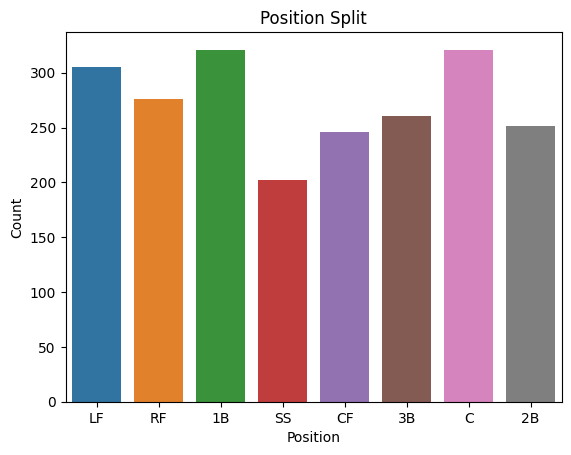

In [10]:
sns.countplot(data=data_clean, x='position')
plt.title('Position Split')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()

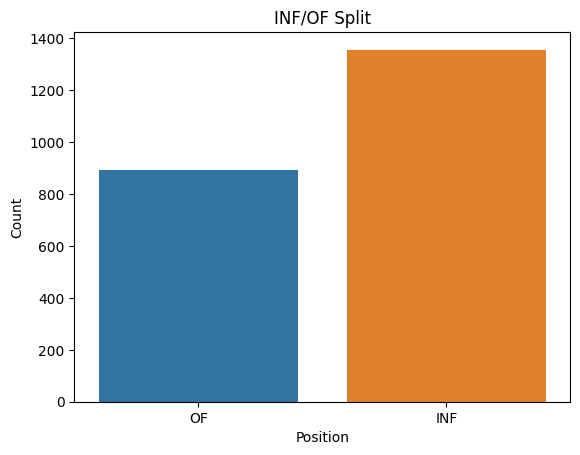

In [11]:
sns.countplot(data=binary_hitters, x='bin_pos')
plt.title('INF/OF Split')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()

### We can see that positions are not quite evenly distributed. This is especially evident in the binary INF/OF case. We'll have to make use of different sampling techniques to balance the data when we train the models going forward. Next, let's check out a correlation matrix

In [12]:
X = binary_hitters.drop(['bin_pos'], axis=1)
y = binary_hitters.bin_pos

y = LabelEncoder().fit_transform(y) #OF = 1, INF = 0

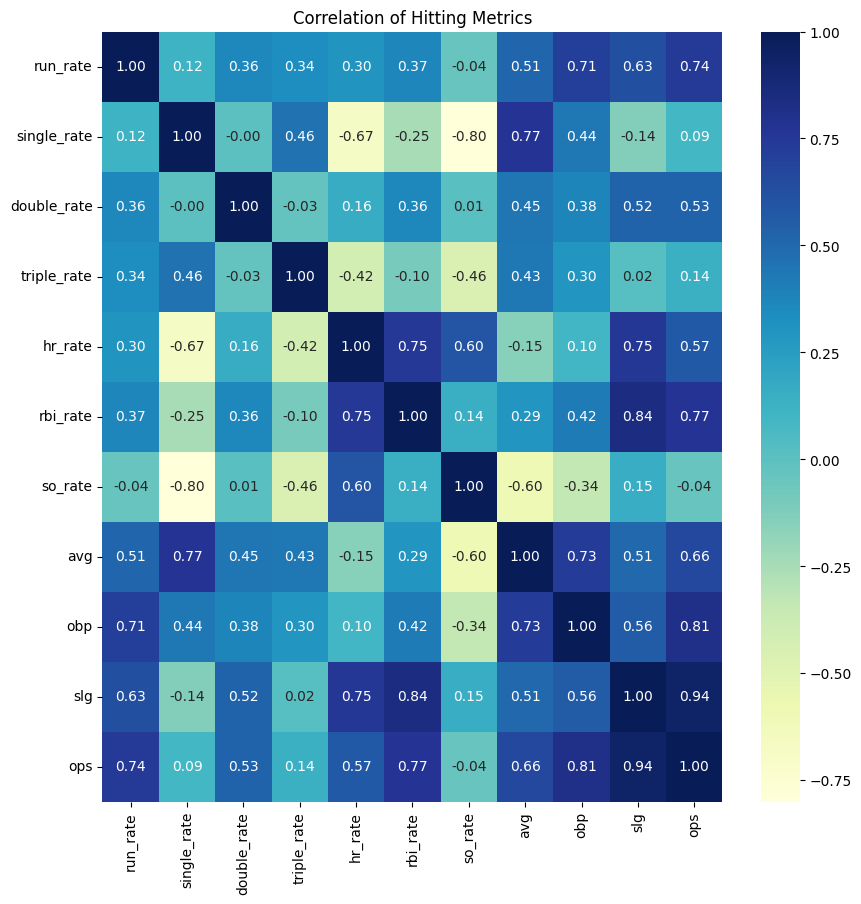

In [13]:
correlation = X.corr()

plt.figure(figsize=(10,10))
sns.heatmap(data=correlation, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Correlation of Hitting Metrics')
plt.show()

### Obviously, a lot of hitting metrics are going to be correlated in some manner. OPS is literally "OBP plus SLG" so the near-perfect correlation is expected. We'll drop this column for model training to reduce the amount of collinearity we're introducting. 

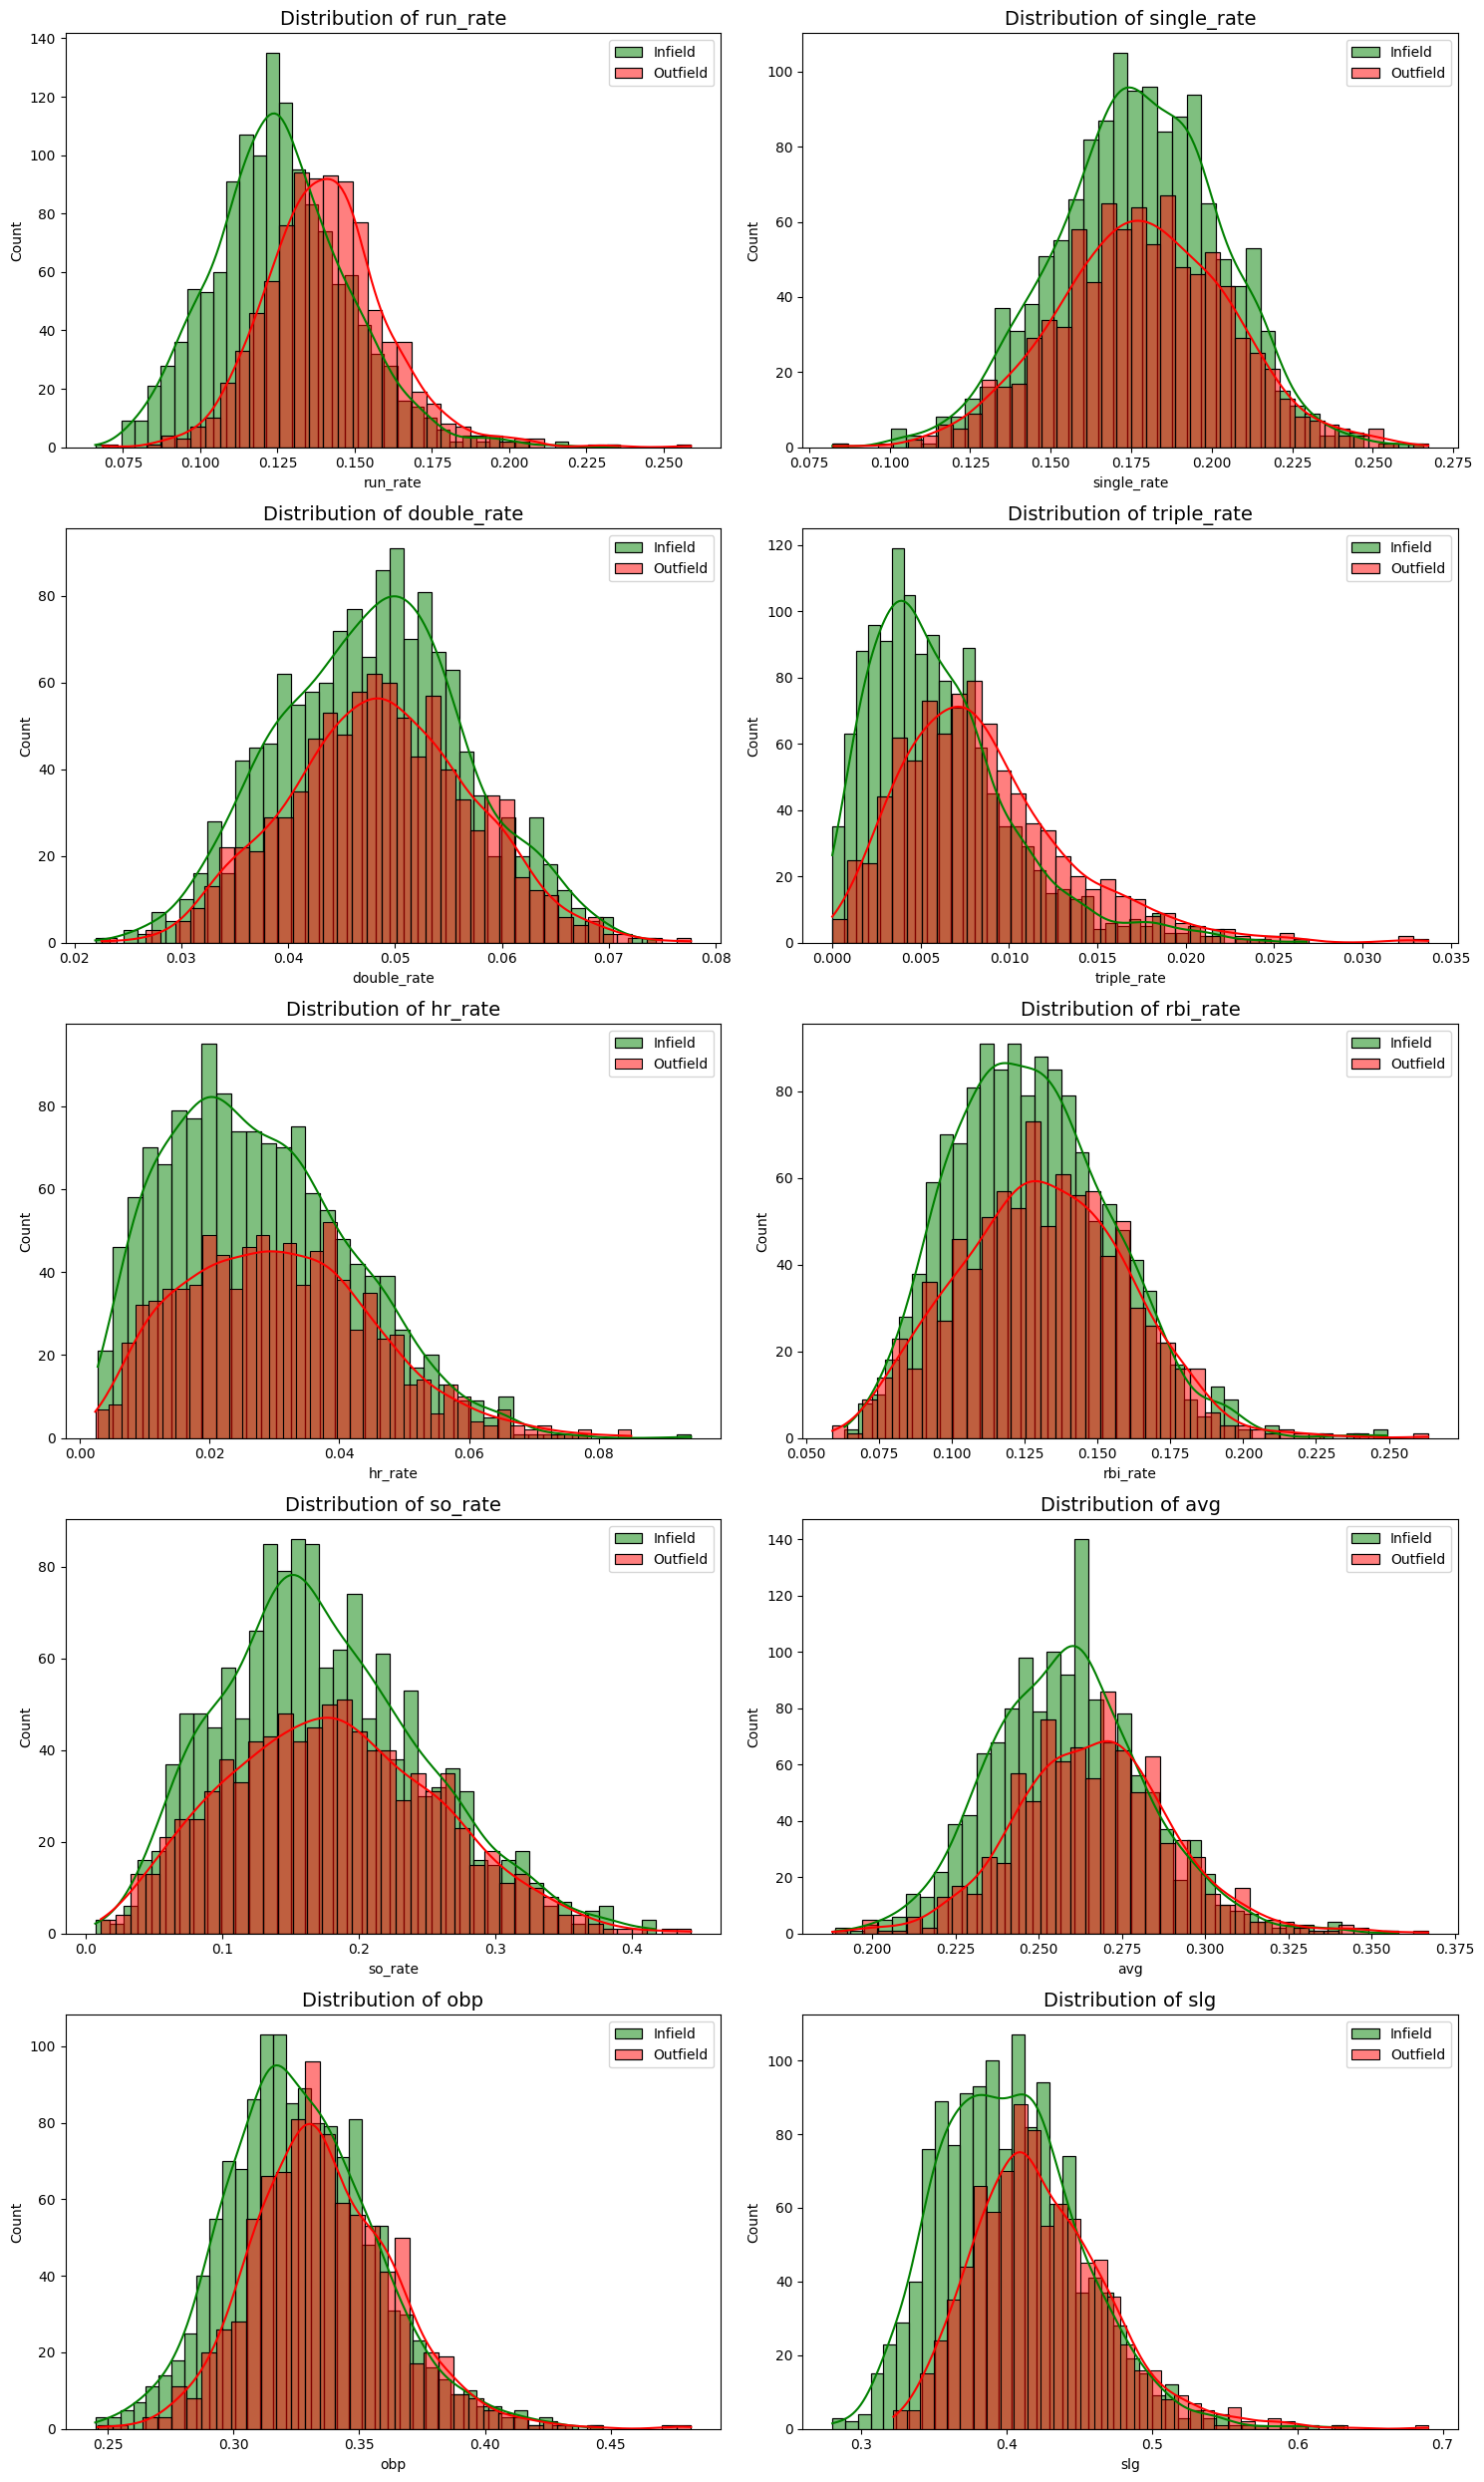

In [14]:
hitting_metrics = ['run_rate', 'single_rate', 'double_rate', 'triple_rate', 'hr_rate', 'rbi_rate', 'so_rate', 'avg', 'obp', 'slg']

infielders = binary_hitters[binary_hitters.bin_pos == 'INF']
outfielders = binary_hitters[binary_hitters.bin_pos == 'OF']

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, metric in zip(axes.ravel(), hitting_metrics):
    sns.histplot(infielders[metric], bins=40, label='Infield', kde=True, color='green', ax=ax, alpha=0.5)
    sns.histplot(outfielders[metric], bins=40, label='Outfield', kde=True, color='red', ax=ax, alpha=0.5)
    
    ax.set_title(f'Distribution of {metric}', fontsize=14)
    ax.legend()

plt.tight_layout()
plt.show()

### We can see from the histograms that there isn't a ton of difference in the distributions of the hitting metrics. However, the distributions mean is slightly higher for Outfielders for most metrics. This lends some credence to the idea that Outfielders need to be better hitters to make up for the easier defensive workload

# Binary Classification

## Logisitic Regression

### Let's split into our training/testing sets. Since we saw above that the classes are imbalanced, we'll use SMOTE to resample the training data.

In [15]:
X = X.drop(columns=['ops'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1883) #The year the Phillies were founded :) 

In [16]:
X_train_resample, y_train_resample = SMOTE(random_state=1883).fit_resample(X_train, y_train)
print(f'Imbalanced class sampling: {Counter(y_train)}')
print(f'Balanced class sampling: {Counter(y_train_resample)}')


Imbalanced class sampling: Counter({0: 944, 1: 631})
Balanced class sampling: Counter({0: 944, 1: 944})


In [17]:
def print_metrics(y_hat, y_true, y_prob=None, multiclass=False):
    acc = accuracy_score(y_true, y_hat)
    prec = precision_score(y_true, y_hat, average=None) if multiclass else precision_score(y_true, y_hat)
    recall = recall_score(y_true, y_hat, average=None) if multiclass else recall_score(y_true, y_hat)
    f1 = f1_score(y_true, y_hat, average=None) if multiclass else f1_score(y_true, y_hat)
    conf_matrix = confusion_matrix(y_true, y_hat)

    if y_prob is not None:
        fpr, tpr, th = roc_curve(y_true, y_prob) 
        auc = roc_auc_score(y_true, y_prob)


        lw = 2
        plt.plot(fpr, tpr, color='blue', lw=lw, label='AUC = %0.2f' % auc)
        plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--') 
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
        print(f'ROC-AUC Score: {auc}')

    print(f'Confusion Matrix: \n {conf_matrix}')
    print(f'Accuracy: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

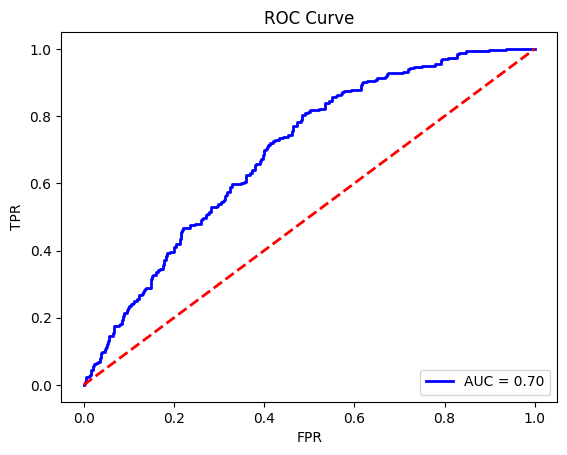

ROC-AUC Score: 0.6956329137288197
Confusion Matrix: 
 [[264 148]
 [ 99 164]]
Accuracy: 0.6340740740740741
Precision: 0.5256410256410257
Recall: 0.623574144486692
F1 Score: 0.5704347826086957


In [18]:
log_clf = LogisticRegression(random_state=1883).fit(X_train_resample, y_train_resample)

y_hat = log_clf.predict(X_test)
y_prob = log_clf.predict_proba(X_test)[:, 1]

print_metrics(y_hat, y_test, y_prob=y_prob)


## KNN

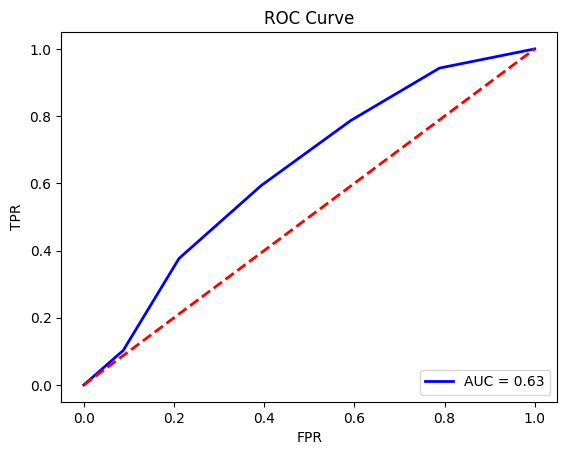

ROC-AUC Score: 0.6349486876591975
Confusion Matrix: 
 [[250 162]
 [107 156]]
Accuracy: 0.6014814814814815
Precision: 0.49056603773584906
Recall: 0.5931558935361216
F1 Score: 0.5370051635111875


In [19]:
knn_clf = KNeighborsClassifier().fit(X_train_resample, y_train_resample)

y_hat = knn_clf.predict(X_test)
y_prob = knn_clf.predict_proba(X_test)[:,1]

print_metrics(y_hat, y_test, y_prob=y_prob)

## SVM

### The next few models (Support Vector Machines and Tree Ensembles) have several hyperparameters that we can tune. Here, we'll use a Grid Search to facilitate hyperparameter tuning. There's a lot we could examine with the Grid Search results but for now we'll just take the best estimator from it and compare those performances against the other models.

In [20]:
log_range = np.logspace(start=-5, stop=5, num=11, base=2)
parameters = {'C': log_range, 'gamma': log_range, 'kernel': ['linear', 'poly', 'rbf']}

svc = SVC(random_state=1883)
svc_grid=GridSearchCV(estimator=svc, param_grid=parameters, n_jobs=-1, cv=5)
svc_grid.fit(X_train_resample,y_train_resample)

GridSearchCV(cv=5, estimator=SVC(random_state=1883), n_jobs=-1,
             param_grid={'C': array([3.125e-02, 6.250e-02, 1.250e-01, 2.500e-01, 5.000e-01, 1.000e+00,
       2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01]),
                         'gamma': array([3.125e-02, 6.250e-02, 1.250e-01, 2.500e-01, 5.000e-01, 1.000e+00,
       2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01]),
                         'kernel': ['linear', 'poly', 'rbf']})

In [21]:
svm_clf = svc_grid.best_estimator_

y_hat = svm_clf.predict(X_test)
print_metrics(y_hat, y_test)

Confusion Matrix: 
 [[283 129]
 [ 76 187]]
Accuracy: 0.6962962962962963
Precision: 0.5917721518987342
Recall: 0.7110266159695817
F1 Score: 0.6459412780656304


## Random Forest

In [22]:
trees = np.linspace(100, 500, 5, endpoint=True, dtype=int)
depth = np.linspace(1, 10, 10, endpoint=True, dtype=int)
samples = np.linspace(0.25, 1, 4, endpoint=True)

parameters = {'n_estimators': trees, 'max_depth': depth, 'max_samples': samples}
tree = RandomForestClassifier(random_state=1883)
tree_grid = GridSearchCV(estimator=tree, param_grid=parameters, n_jobs=-1, cv=5)
tree_grid.fit(X_train_resample, y_train_resample)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1883),
             n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'max_samples': array([0.25, 0.5 , 0.75, 1.  ]),
                         'n_estimators': array([100, 200, 300, 400, 500])})

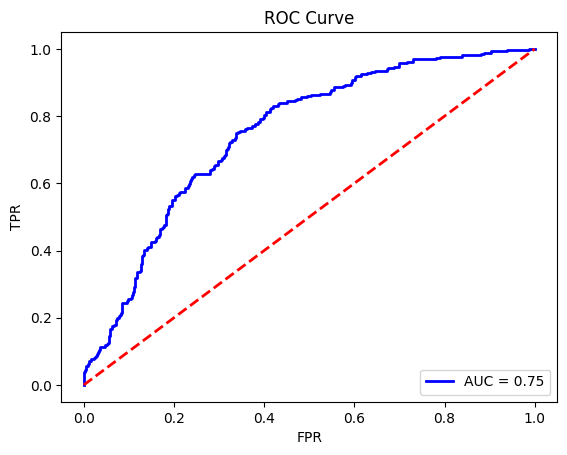

ROC-AUC Score: 0.7499907711617262
Confusion Matrix: 
 [[293 119]
 [ 93 170]]
Accuracy: 0.6859259259259259
Precision: 0.5882352941176471
Recall: 0.6463878326996197
F1 Score: 0.6159420289855072


In [23]:
rf_clf = tree_grid.best_estimator_

y_hat = rf_clf.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)[:, 1]

print_metrics(y_hat, y_test, y_prob)

## Boosted Trees

In [24]:
trees = np.linspace(50, 500, 10, endpoint=True, dtype=int)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
parameters = {'n_estimators': trees, 'learning_rate': learning_rate}

base = AdaBoostClassifier(random_state=1883)
ada_grid = GridSearchCV(estimator=base, param_grid=parameters, n_jobs=-1, cv=5)
ada_grid.fit(X_train_resample, y_train_resample)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=1883), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])})

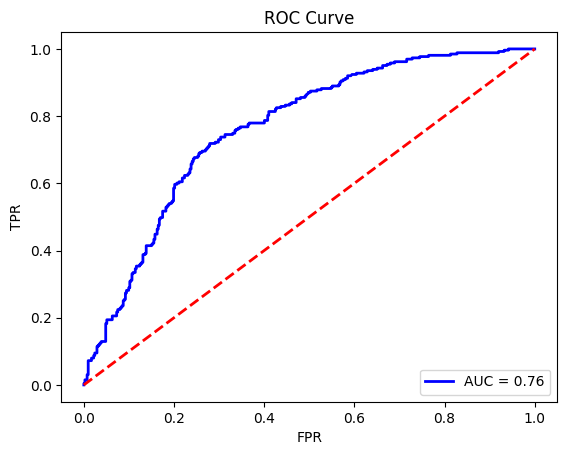

ROC-AUC Score: 0.7640509062719185
Confusion Matrix: 
 [[297 115]
 [ 75 188]]
Accuracy: 0.7185185185185186
Precision: 0.6204620462046204
Recall: 0.714828897338403
F1 Score: 0.6643109540636043


In [25]:
ada_clf = ada_grid.best_estimator_

y_hat = ada_clf.predict(X_test)
y_prob = ada_clf.predict_proba(X_test)[:, 1]

print_metrics(y_hat, y_test, y_prob)

# Multi-Class Classification

In [26]:
multi_pos = data_clean.drop(columns=['ops'])
X_multi = multi_pos.drop(columns=['position'])
y_multi = multi_pos.position

y_multi = LabelEncoder().fit_transform(y_multi)

In [27]:
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_multi, y_multi, test_size=.3, random_state=1883)
X_m_resample, y_m_resample = SMOTE(random_state=1883).fit_resample(X_m_train, y_m_train)
print(f'Imbalanced class sampling: {Counter(y_m_train)}')
print(f'Balanced class sampling: {Counter(y_m_resample)}')

Imbalanced class sampling: Counter({3: 228, 5: 215, 0: 210, 6: 196, 2: 183, 4: 180, 1: 173, 7: 143})
Balanced class sampling: Counter({7: 228, 1: 228, 6: 228, 5: 228, 2: 228, 0: 228, 3: 228, 4: 228})


## KNN

In [28]:
neighbors = [1, 3, 5, 10, 15, 20]
powers = [1, 2, 3]
weights = ['uniform', 'distance']
parameters = {'n_neighbors': neighbors, 'p': powers, 'weights': weights}

base = KNeighborsClassifier(n_jobs=-1)
knn_grid = GridSearchCV(estimator=base, param_grid=parameters, n_jobs=-1, cv=5)
knn_grid.fit(X_m_resample, y_m_resample)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 10, 15, 20], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']})

In [29]:
knn_m_clf = knn_grid.best_estimator_

y_hat = knn_m_clf.predict(X_m_test)
print_metrics(y_hat, y_m_test, multiclass=True)

Confusion Matrix: 
 [[28  4 14 20  6 17 14  8]
 [ 7 11  5 12 16  5  6 16]
 [ 9  4 17 11  6 12  9 10]
 [14  4 12 37  4  6  9  7]
 [ 3  6  8  5 15 11  9  9]
 [10 15 16  7  8 11 13 10]
 [11  7 11  6  8 19 12  6]
 [ 4 15  4  1  8  7  5 15]]
Accuracy: 0.22290076335877862
Precision: [0.3255814  0.16666667 0.1954023  0.37373737 0.21126761 0.125
 0.15584416 0.18518519]
Recall: [0.25225225 0.14102564 0.21794872 0.39784946 0.22727273 0.12222222
 0.15       0.25423729]
F1 Score: [0.28426396 0.15277778 0.20606061 0.38541667 0.2189781  0.12359551
 0.15286624 0.21428571]


## Bagged/Boosted Trees

In [30]:
trees = np.linspace(50, 1000, 20, endpoint=True, dtype=int)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
parameters = {'n_estimators': trees, 'learning_rate': learning_rate}

base = AdaBoostClassifier(random_state=1883)
ada_m_grid = GridSearchCV(estimator=base, param_grid=parameters, n_jobs=-1, cv=5)
ada_m_grid.fit(X_m_resample, y_m_resample)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=1883), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
                         'n_estimators': array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000])})

In [31]:
ada_m_clf = ada_m_grid.best_estimator_

y_hat = ada_m_clf.predict(X_m_test)

print_metrics(y_hat, y_m_test, multiclass=True)

Confusion Matrix: 
 [[38  3 12 17  3 16 20  2]
 [ 4 16  6  3 11  6  4 28]
 [14  5 18 10  5  4 12 10]
 [17  3 11 45  1  3  5  8]
 [ 1  9  7  0 26  4 13  6]
 [14  5 10  5 20  5 27  4]
 [17  2  8  3  9  5 28  8]
 [ 2  9  8  4  3  2 10 21]]
Accuracy: 0.300763358778626
Precision: [0.35514019 0.30769231 0.225      0.51724138 0.33333333 0.11111111
 0.23529412 0.24137931]
Recall: [0.34234234 0.20512821 0.23076923 0.48387097 0.39393939 0.05555556
 0.35       0.3559322 ]
F1 Score: [0.34862385 0.24615385 0.2278481  0.5        0.36111111 0.07407407
 0.28140704 0.28767123]


# Results/Analysis

# Conclusions